In [142]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter
from nltk.stem import WordNetLemmatizer

import seaborn as sns

import string

import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [143]:
all_data = pd.read_csv('complete_dataset/combined_sentiment_analysis.csv')


In [144]:
all_data.shape

(14330, 8)

In [145]:
all_data

,comment_body,comment_score,sentiment,neg,neu,pos,compound,subreddit
0,I can't wait for him to file evidence that she...,1608,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,1.000,0.000,0.0000,politics
1,"""Here is a receipt labeled 'Bribe for Judge Ca...",1316,"{'neg': 0.196, 'neu': 0.804, 'pos': 0.0, 'comp...",0.196,0.804,0.000,-0.4423,politics
2,I think the Supreme Court ruled that is just f...,578,"{'neg': 0.0, 'neu': 0.597, 'pos': 0.403, 'comp...",0.000,0.597,0.403,0.6597,politics
3,"Hey Cannon, remember Ricky Shiffer the derange...",513,"{'neg': 0.196, 'neu': 0.763, 'pos': 0.041, 'co...",0.196,0.763,0.041,-0.7968,politics
4,Cannon has no clue what she's getting into. Wh...,494,"{'neg': 0.038, 'neu': 0.741, 'pos': 0.221, 'co...",0.038,0.741,0.221,0.8248,politics
...,...,...,...,...,...,...,...,...
14325,How are we sure that is done by pro-palestine?...,-96,"{'neg': 0.161, 'neu': 0.739, 'pos': 0.1, 'comp...",0.161,0.739,0.100,-0.3400,worldnews
14326,[removed],-109,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,1.000,0.000,0.0000,worldnews
14327,Strange how the IDF just shot down some hostag...,-138,"{'neg': 0.13, 'neu': 0.87, 'pos': 0.0, 'compou...",0.130,0.870,0.000,-0.2023,worldnews
14328,How is it protecting Jewish people living in t...,-196,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,1.000,0.000,0.0000,worldnews


In [146]:
sid = SentimentIntensityAnalyzer()

In [147]:
class SentimentExtractor(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        sentiment_scores = X.apply(lambda comment: sid.polarity_scores(comment) if isinstance(comment, str) else {'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound': 0.0})
        return pd.DataFrame(sentiment_scores.tolist())

In [161]:
standard_stopwords = set(stopwords.words('english'))

custom_stopwords = set([
    'like', 'would', 'get', 'one', 'people'
])

combined_stopwords = standard_stopwords.union(custom_stopwords)

pipe = Pipeline([
    ('features', FeatureUnion([
        ('tfidf', TfidfVectorizer(stop_words='english', max_features=500)),
        ('sentiment', SentimentExtractor())
    ])),
    ('scaler', StandardScaler(with_mean=False)),
    ('rf', RandomForestClassifier(random_state=42))
])

In [162]:
pgrid = {
    'features__tfidf__max_features': [300, 500],
    'rf__n_estimators': [100, 200],
    'rf__max_depth': [10, 20],
    'rf__min_samples_split': [2, 5],
    'rf__min_samples_leaf': [1, 2]
}

In [163]:
gs = GridSearchCV(pipe, pgrid, cv=5, n_jobs=4, verbose=1)

In [164]:
y = all_data['subreddit'].map({'politics': 0, 'worldnews': 1}).values

In [165]:
X_train, X_test, y_train, y_test = train_test_split(all_data['comment_body'], y, test_size=0.2, random_state=42)

In [166]:
%%time
gs.fit(X_train, y_train)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
CPU times: total: 3.45 s
Wall time: 4min 3s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('features',
                                        FeatureUnion(transformer_list=[('tfidf',
                                                                        TfidfVectorizer(max_features=500,
                                                                                        stop_words='english')),
                                                                       ('sentiment',
                                                                        SentimentExtractor())])),
                                       ('scaler',
                                        StandardScaler(with_mean=False)),
                                       ('rf',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=4,
             param_grid={'features__tfidf__max_features': [300, 500],
                         'rf__max_depth': [10, 20],
                         'rf__min_samples_leaf': [1, 2],
                         'rf__min_samples_split': [2, 5],
                         'rf__n_estimators': [100, 200]},
             verbose=1)

In [167]:
best_model = gs.best_estimator_
best_model

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('tfidf',
                                                 TfidfVectorizer(max_features=500,
                                                                 stop_words='english')),
                                                ('sentiment',
                                                 SentimentExtractor())])),
                ('scaler', StandardScaler(with_mean=False)),
                ('rf', RandomForestClassifier(max_depth=20, random_state=42))])

In [168]:
y_pred = best_model.predict(X_test)

In [169]:
best_model.score(X_train, y_train)

0.7826238660153524

In [170]:
best_model.score(X_test, y_test)

0.7595952547103978

In [88]:
all_data = pd.read_csv('complete_dataset/combined_sentiment_analysis.csv')


In [89]:
politics_data = all_data[all_data['subreddit'] == 'politics']
worldnews_data = all_data[all_data['subreddit'] == 'worldnews']

In [90]:
def preprocess_text(text):
    tokens = word_tokenize(text.lower())
    tokens = [word for word in tokens if word.isalnum() and word not in stopwords.words('english')]
    return tokens

In [91]:
politics_data['tokens'] = politics_data['comment_body'].apply(lambda x: preprocess_text(str(x)))
worldnews_data['tokens'] = worldnews_data['comment_body'].apply(lambda x: preprocess_text(str(x)))

C:\Users\rswin\AppData\Local\Temp\ipykernel_31220\1660939851.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  politics_data['tokens'] = politics_data['comment_body'].apply(lambda x: preprocess_text(str(x)))
C:\Users\rswin\AppData\Local\Temp\ipykernel_31220\1660939851.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  worldnews_data['tokens'] = worldnews_data['comment_body'].apply(lambda x: preprocess_text(str(x)))


In [92]:
politics_words = Counter([word for tokens in politics_data['tokens'] for word in tokens])
worldnews_words = Counter([word for tokens in worldnews_data['tokens'] for word in tokens])

In [93]:
politics_df = pd.DataFrame(politics_words.items(), columns=['word', 'count']).sort_values(by='count', ascending=False)
worldnews_df = pd.DataFrame(worldnews_words.items(), columns=['word', 'count']).sort_values(by='count', ascending=False)

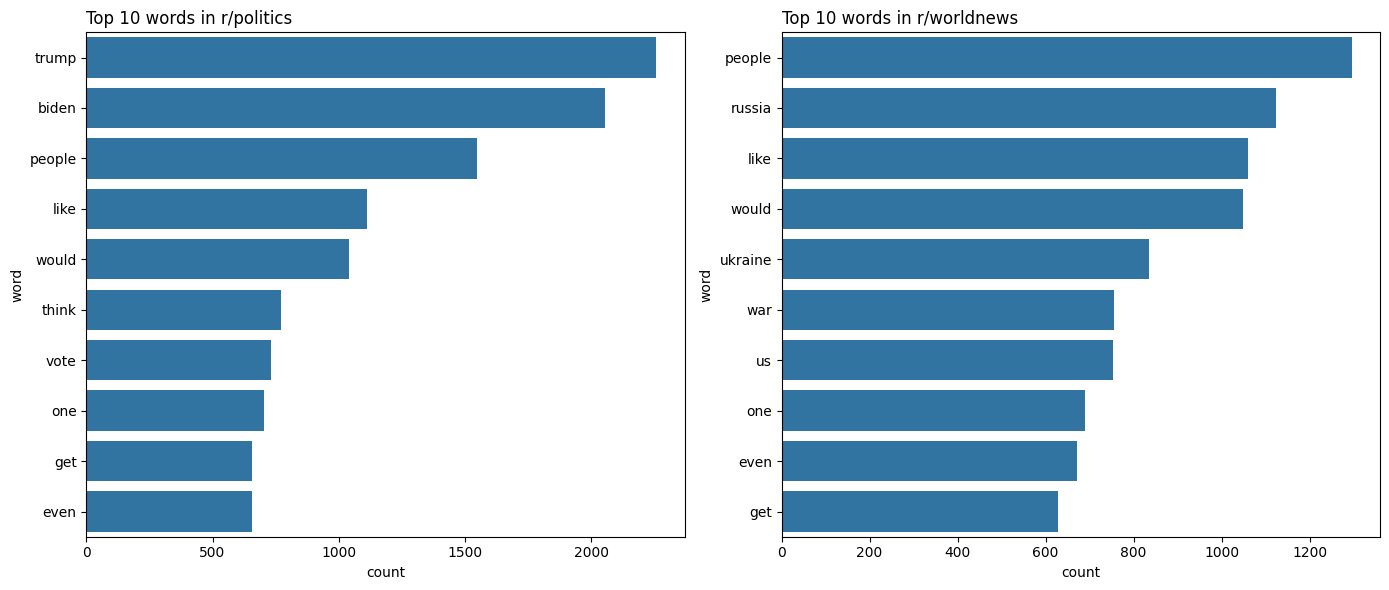

In [95]:
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.barplot(y='word', x='count', data=politics_df.head(10))
plt.title('Top 10 words in r/politics', loc='left')

plt.subplot(1, 2, 2)
sns.barplot(y='word', x='count', data=worldnews_df.head(10))
plt.title('Top 10 words in r/worldnews', loc='left')

plt.tight_layout()
plt.show()